In [ ]:
!pip install -U torch torchvision transformers pillow scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 859.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "openai/clip-vit-base-patch16"

model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

model.eval()
print("Device:", device)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Device: cuda


In [ ]:
texts = [
    "a chest x-ray image showing pneumonia",
    "a normal chest x-ray image"
]


In [ ]:
import os
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

test_dir = "/content/drive/MyDrive/chest_xray/test"

y_true, y_pred = [], []

with torch.no_grad():
    for label, cls in enumerate(["NORMAL", "PNEUMONIA"]):
        class_dir = os.path.join(test_dir, cls)

        for img_name in tqdm(os.listdir(class_dir), desc=cls):
            img_path = os.path.join(class_dir, img_name)

            image = Image.open(img_path).convert("RGB")

            inputs = processor(
                text=texts,
                images=image,
                return_tensors="pt",
                padding=True
            ).to(device)

            outputs = model(**inputs)
            logits = outputs.logits_per_image
            pred = logits.argmax(dim=1).item()

            y_pred.append(pred)
            y_true.append(label)


PNEUMONIA: 100%|██████████| 390/390 [00:29<00:00, 13.26it/s]


In [ ]:
acc = accuracy_score(y_true, y_pred)
p, r, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary"
)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {p:.4f}")
print(f"Recall   : {r:.4f}")
print(f"F1-score : {f1:.4f}")


Accuracy : 0.3798
Precision: 1.0000
Recall   : 0.0077
F1-score : 0.0153


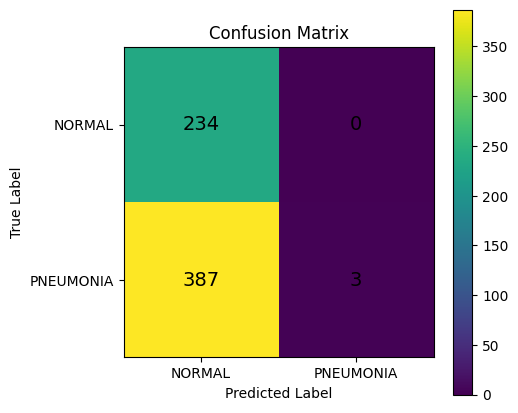

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["NORMAL", "PNEUMONIA"]
plt.xticks([0,1], classes)
plt.yticks([0,1], classes)

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", fontsize=14)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


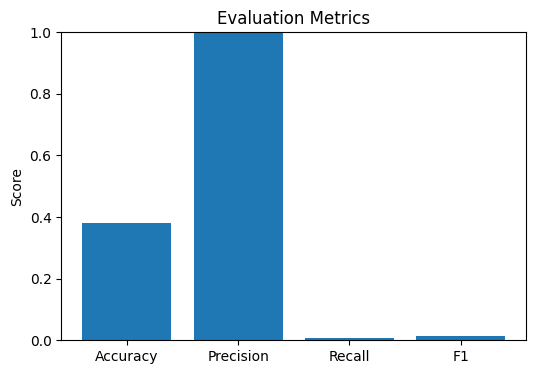

In [ ]:
metrics = [acc, prec, rec, f1]
names = ["Accuracy", "Precision", "Recall", "F1"]

plt.figure(figsize=(6,4))
plt.bar(names, metrics)
plt.ylim(0,1)
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.show()


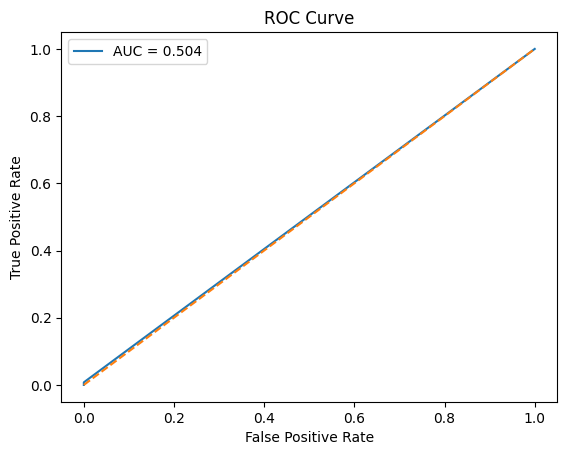

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


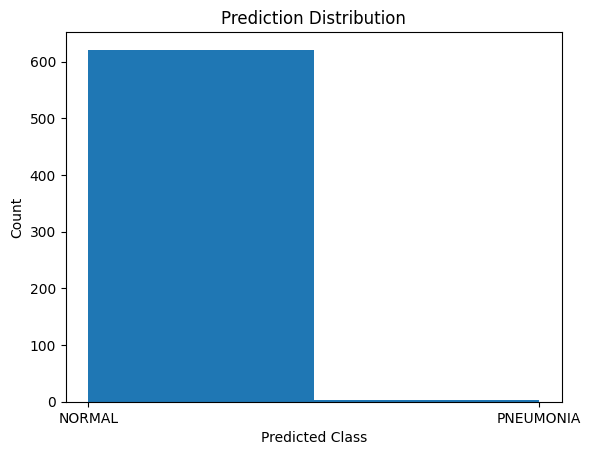

In [ ]:
plt.figure()
plt.hist(y_pred, bins=2)
plt.xticks([0,1], ["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Prediction Distribution")
plt.show()


In [3]:
import os

base_path = "/content/drive/MyDrive/chest-xray-medclip"

os.makedirs(
    f"{base_path}/experiments/exp1_zero_shot_evaluation",
    exist_ok=True
)

print("Directory created.")


Directory created.


In [6]:
import json

zero_shot_results = {
    "experiment": "zero_shot",
    "model": "openai/clip-vit-base-patch16",
    "dataset": "Chest X-ray Pneumonia (Kaggle)",
    "accuracy": 0.3798,
    "precision": 1.0000,
    "recall": 0.0077,
    "f1_score": 0.0153
}

with open(
    f"{base_path}/experiments/exp1_zero_shot_evaluation/results.json",
    "w"
) as f:
    json.dump(zero_shot_results, f, indent=4)

print("Zero-shot results saved successfully.")


Zero-shot results saved successfully.


In [7]:
!ls /content/drive/MyDrive/chest-xray-medclip/experiments/exp1_zero_shot_evaluation


results.json
